# Whatsapp Chat Analysis
# Erick Hernandez

Import required libraries

In [51]:
from PIL import Image, ImageDraw, ImageFont
import calmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import emoji
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Plot Style
plt.style.use('ggplot')

In [52]:
emojis=[]
for string in df.Message:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI:
            emojis.append(each)

define function to read and clean whatsapp chat file

In [3]:
def read_whatsapp(path):
    raw = open(path, encoding='utf-8')
    chats = raw.readlines()
    messages = []
    name = []
    time = []

    for line in chats:
        if len(line.split(' - '))!=1:
            if len(line.split(' - ')[1].split(': '))==2:
                name.append(line.split(' - ')[1].split(':')[0])
                messages.append(line.split(' - ')[1].split(':')[1].rstrip('\n'))
                time.append(line.split(' - ')[0])
        else:
            messages[-1] = messages[-1] + " " + line

    df = pd.DataFrame({"message":messages, "name":name, 'time':time})
    df["time"] = pd.to_datetime(df["time"])


    return df

we can also import Line chat file

In [4]:
def read_line(path):
    raw = open(path, encoding='utf-8')
    chats = raw.readlines()
    messages = []
    name = []
    time = []
    
    for i, line in enumerate(chats):
        if line.split('\t')[0]=="\n":
            date = chats[i+1].rsplit("(", 2)[0]
        elif len(line.split('\t'))==3:
            name.append(line.split('\t')[1])
            messages.append(line.split('\t')[2].rstrip())
            time.append(datetime.strptime(date + " " + line.split('\t')[0], '%Y/%m/%d %H:%M'))
    
    df = pd.DataFrame({"message":messages, "name":name, 'time':time})
    
    return df

In [5]:
chat = read_whatsapp("WhatsApp Chat with Friends Toptops Forever.txt")

### Timeline

In [6]:
def timeline(df):
    days = (df.time.iloc[-1] - df.time.iloc[0]).days
    first_day = datetime.strftime(df.time.iloc[0], format="%A, %d %b %Y")
    last_day = datetime.strftime(df.time.iloc[-1], format="%A, %d %b %Y")

    day_img = Image.open("img/day.png")
    img = ImageDraw.Draw(day_img)
    font = ImageFont.truetype(font="corbel.ttf", size=40)
    font_day = ImageFont.truetype(font="corbel.ttf", size=24)
    font_date = ImageFont.truetype(font="corbel.ttf", size=27)
    img.text((290,130), str(days), font=font, fill=(0, 0, 0))
    img.text((360,140), "days", font=font_day, fill=(0, 0, 0))
    img.text((120,50), first_day, font=font_date, fill=(0, 0, 0))
    img.text((120,220), last_day, font=font_date, fill=(0, 0, 0))
    return day_img

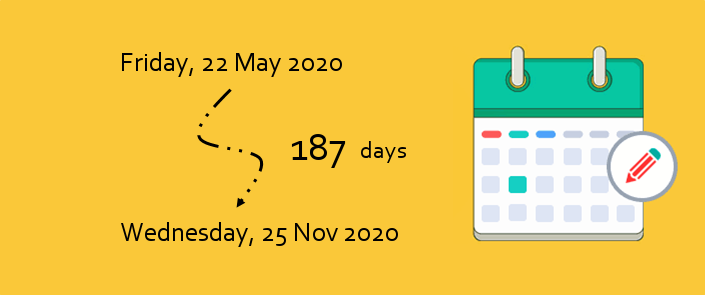

In [7]:
timeline(chat)

### Number of messages

In [8]:
def messages_summary(df):
    total_message = len(df.index)
    average_message_day = df.set_index(df.time).message.resample("D").count().mean()
    average_message_week = df.set_index(df.time).message.resample("W").count().mean()
    average_message_month = df.set_index(df.time).message.resample("M").count().mean()
    users = {user: df[df.name == user] for user in df.name.unique()}

    chat_img = Image.open("img/chat_1.png")
    img = ImageDraw.Draw(chat_img)
    font = ImageFont.truetype(font="arial.ttf", size=20)
    font_2 = ImageFont.truetype(font="arial.ttf", size=13)
    img.text((100,100), str(total_message), font=font, fill=(0,128,128))
    img.text((78,120), "Messages", font=font, fill=(0,128,128))
    img.text((240,70), ("Daily Average messages {:0.0f}".format(average_message_day)), font=font_2, fill=(0,128,128))
    img.text((240,90), ("Weekly Average messages {:0.0f}".format(average_message_week)), font=font_2, fill=(0,128,128))
    img.text((240,110), ("Monthly Average messages {:0.0f}".format(average_message_month)), font=font_2, fill=(0,128,128))
    for i, user in enumerate(users):
        img.text((240,120+(i+1)*20), ("Number of messages " + user + " sent {:0.0f}".format(len(users[user].index))), font=font_2, fill=(0,128,128))
    
    return chat_img

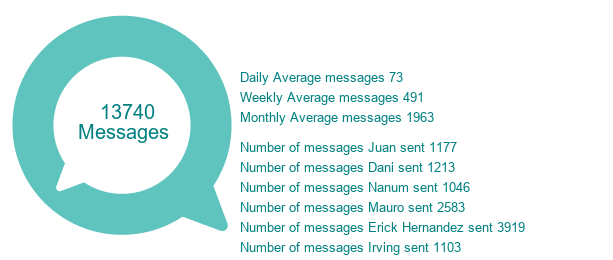

In [9]:
messages_summary(chat)

### Siapa yang sering chat duluan

In [10]:
def chat_initiator(df):
    dff = df.copy()
    dff["response_time"] = dff.time.diff()

    dff["response_time_s"] = dff.response_time - timedelta(hours=12)
    dff["response_time_s"] = dff.response_time_s.apply(lambda x: x.total_seconds())
    chat_duluan = dff[dff["response_time_s"] > 0]
    chat_duluan_count = chat_duluan.groupby("name").count()

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(chat_duluan_count.message, labels=chat_duluan_count.index, colors=['teal','turquoise'])
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    p.set_size_inches(5,5)
    plt.title("¿Quién suele empezar a chatear primero?", fontsize=14)
    plt.savefig("chat_initiator.jpg")
    plt.show()

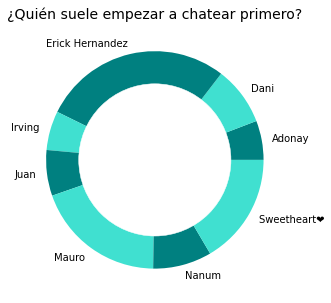

In [11]:
chat_initiator(chat)

### Siapa yang sering delete chat

In [12]:
def delete_chat(df):
    deleted = df[df["message"].str.contains('delete')].groupby("name").count()
    plt.title("Quien a menudo borra chat", fontsize=14)
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(deleted.message, labels=deleted.index, colors=['teal','turquoise'])
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    p.set_size_inches(5,5)
    plt.savefig("delete_chat.jpg")
    plt.show()


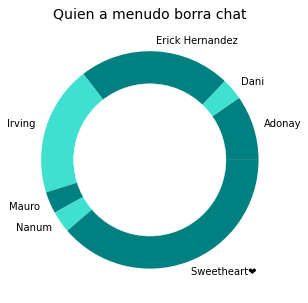

In [13]:
delete_chat(chat)

### Siapa yang balesnya cepet

In [14]:
def chat_reply(df):
    dff = df.copy()
    dff["response_time"] = dff.time.diff()

    dff["response_time_s"] = dff.response_time - timedelta(hours=12)
    dff["response_time_s"] = dff.response_time_s.apply(lambda x: x.total_seconds())
    response_time_obj = dff[dff["response_time_s"] < 0]
    response_time_obj["response_time_s"] = response_time_obj.response_time.values.astype("int64")

    bales_chat = response_time_obj.groupby("name").mean()
    bales_chat["response_time_s"] = pd.to_timedelta(bales_chat["response_time_s"])

    a=bales_chat.response_time_s.apply(lambda x: x.total_seconds())
    minutes=a//60
    seconds=a-(minutes*60)

    value=bales_chat.response_time_s.values.astype("float64")/60/1000000000
    ax=sns.barplot(x=value, y=bales_chat.index, color='orange')
    ax.set_xlabel('Minutos')
    for i in range(len(bales_chat.index)):
        plt.text(x = value[i]-value[i]+0.1 , y = i, s = '{:02} minutos {:02} seg'.format(int(minutes[i]), int(seconds[i])), size = 14, withdash=True, color="snow")
    plt.title("¿Quién recibió la respuesta rápida?", fontsize=14)
    plt.savefig("chat_reply.jpg")
    plt.show()

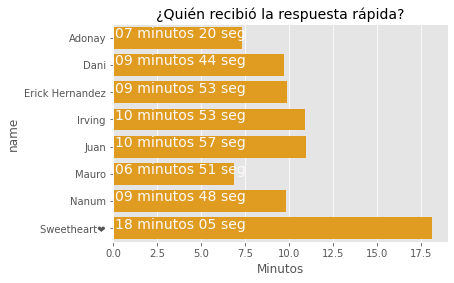

In [15]:
chat_reply(chat)

In [55]:
emoji_df = pd.DataFrame(emojis)
emoji_df = emoji_df[0].value_counts().head(10).reset_index()
emoji_df.columns = ['Emojis', 'Frequency']
emoji_messages = emoji_df.Frequency.sum()
emoji_df

,Emojis,Frequency
0,😂,253
1,🥺,251
2,❤,70
3,🥴,62
4,👀,56
5,🤭,46
6,♥,42
7,😍,41
8,🏻,39
9,👌,33


### Tukang spam sticker

In [16]:
def spam_sticker(df):
    sticker_text = ["<Media omitted>", "\[Sticker\]"]
    df[df["message"].str.contains('|'.join(sticker_text ))]
    stiker = df[df["message"].str.contains('|'.join(sticker_text ))].groupby("name").count()

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(stiker.message, labels=stiker.index, colors=['teal','turquoise'])
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    p.set_size_inches(5,5)
    plt.savefig("spam_sticker.jpg")
    plt.show()

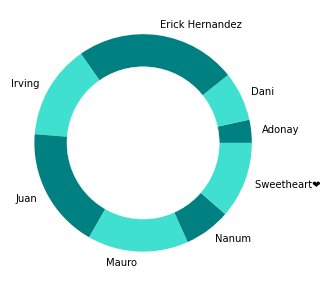

In [17]:
spam_sticker(chat)

In [48]:
multimedia = df.Message.value_counts()
multimedia = multimedia[0]
multimedia

1954

### Weekly activity

In [46]:
df[['Time','User']] = df["Time"].str.split(" - ",expand=True,n=1)
df

,Date,Time,User
0,"5/22/20,",6:07 pm,Messages and calls are end-to-end encrypted. N...
1,"2/7/17,",10:50 pm,"+52 999 228 2469 created group ""Friends Toptop..."
2,"2/7/17,",10:50 pm,You were added
3,"5/22/20,",5:30 pm,Juan: Sí quieren yo me salgo
4,"5/22/20,",5:30 pm,Juan: Y le dejan el lugar al wey ese
...,...,...,...
13837,"11/25/20,",3:32 pm,Dani: Uh
13838,"11/25/20,",3:32 pm,Dani: Vrg y el resto es para irte?
13839,"11/25/20,",3:37 pm,Erick Hernandez: Simon
13840,"11/25/20,",11:34 pm,Adonay: Para venirse en mi boca way


### Daily Activity

In [36]:
def daily_activity_bar(df):
    df["DayofWeek"]=df.index.dayofweek
    df["DayofWeek"].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}, inplace=True)

    daily = df.groupby(['DayofWeek']).count()
    daily = daily.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

    fig=plt.gcf()
    ax=plt.subplot()
    sns.barplot(y=daily['message'], x=daily.index, color="teal")
    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Daily Activity",fontsize=14)
    plt.savefig('daily_activity_bar.jpg')
    plt.show()

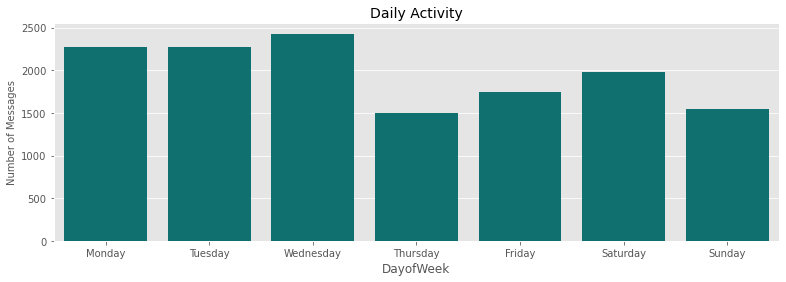

In [37]:
daily_activity_bar(chat)

In [38]:
def daily_activity_polar(df):
    df["DayofWeek"]=df.index.dayofweek
    df["DayofWeek"].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}, inplace=True)

    daily = df.groupby(['DayofWeek']).count()
    daily = daily.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

    angles=np.linspace(0, 2*np.pi, len(daily.index), endpoint=False)
    # close the plot
    stats=(np.concatenate((daily['message'],[daily['message'][0]])))
    angles=np.flip(np.concatenate((angles,[angles[0]])))


    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, color="teal")
    ax.fill(angles, stats, alpha=0.25, color="turquoise")
    ax.set_thetagrids(angles * 180/np.pi, daily.index, fontsize=11, weight="bold")
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    fig.set_size_inches(6,6)
    ax.grid(True)
    plt.savefig('daily_activity_polar.jpg')
    plt.show()

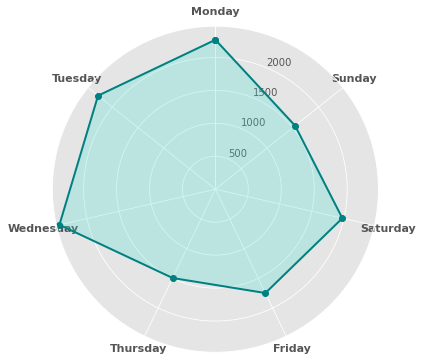

In [39]:
daily_activity_polar(chat)

### Hourly Activity

In [40]:
def hourly_activity_map(df):
    df['Hour']=pd.to_datetime(df.index.to_series()).apply(lambda x: x.strftime('%H'))
    hourly = df.groupby("Hour").count()

    fig=plt.gcf()
    ax=plt.subplot()

    plt.fill_between( x=hourly.index, y1=hourly.message, color="teal", alpha=0.4)
    plt.plot(hourly.message, color="turquoise", alpha=0.6)

    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Hourly Activity",fontsize=14)
    plt.savefig('hourly_activity_map.jpg')
    plt.show()

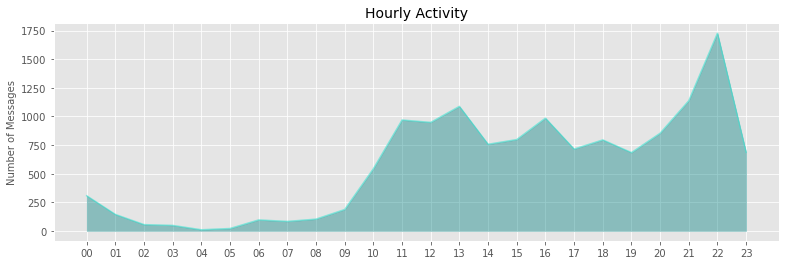

In [41]:
hourly_activity_map(chat)

In [43]:
df = pd.read_table('WhatsApp Chat with Friends Toptops Forever.txt',names=['Date'])
df.head()

,Date
0,"5/22/20, 6:07 pm - Messages and calls are end-..."
1,"2/7/17, 10:50 pm - +52 999 228 2469 created gr..."
2,"2/7/17, 10:50 pm - You were added"
3,"5/22/20, 5:30 pm - Juan: Sí quieren yo me salgo"
4,"5/22/20, 5:30 pm - Juan: Y le dejan el lugar a..."


In [44]:
df[['Date','Time']] = df["Date"].str.split(" ",expand=True,n=1)
df

,Date,Time
0,"5/22/20,",6:07 pm - Messages and calls are end-to-end en...
1,"2/7/17,","10:50 pm - +52 999 228 2469 created group ""Fri..."
2,"2/7/17,",10:50 pm - You were added
3,"5/22/20,",5:30 pm - Juan: Sí quieren yo me salgo
4,"5/22/20,",5:30 pm - Juan: Y le dejan el lugar al wey ese
...,...,...
13837,"11/25/20,",3:32 pm - Dani: Uh
13838,"11/25/20,",3:32 pm - Dani: Vrg y el resto es para irte?
13839,"11/25/20,",3:37 pm - Erick Hernandez: Simon
13840,"11/25/20,",11:34 pm - Adonay: Para venirse en mi boca way


In [47]:
df[['User','Message']] = df["User"].str.split(":",expand=True,n=1)
df

,Date,Time,User,Message
0,"5/22/20,",6:07 pm,Messages and calls are end-to-end encrypted. N...,None
1,"2/7/17,",10:50 pm,"+52 999 228 2469 created group ""Friends Toptop...",None
2,"2/7/17,",10:50 pm,You were added,None
3,"5/22/20,",5:30 pm,Juan,Sí quieren yo me salgo
4,"5/22/20,",5:30 pm,Juan,Y le dejan el lugar al wey ese
...,...,...,...,...
13837,"11/25/20,",3:32 pm,Dani,Uh
13838,"11/25/20,",3:32 pm,Dani,Vrg y el resto es para irte?
13839,"11/25/20,",3:37 pm,Erick Hernandez,Simon
13840,"11/25/20,",11:34 pm,Adonay,Para venirse en mi boca way


In [62]:

from wordcloud import WordCloud

In [73]:
w = ['JAJAJAJA', 'Whatsapp', 'Data-Science', 'WHATSAPP', 'ERICK HERNANDEZ',' GAY', '<3','<3']
# w = ['Artificial Intelligence     ']

(-0.5, 399.5, 199.5, -0.5)

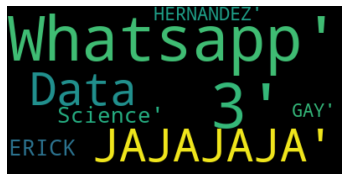

In [74]:

wc = WordCloud().generate(str(w))
plt.imshow(wc, interpolation = 'bilinear')

plt.axis('off')